# Data Preprocess

In [29]:
import cv2
import os

# 입력 디렉토리와 출력 디렉토리 설정
input_dir = "/home/jinjinjara1022/AI_Term/cell_survival_rate/Dataset/origin"
output_dir = "/home/jinjinjara1022/AI_Term/cell_survival_rate/Dataset/cell_detection"
visualization_dir = "/home/jinjinjara1022/AI_Term/cell_survival_rate/Dataset/visualizations"

# 출력 디렉토리 생성
os.makedirs(output_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)

# 고정된 바운딩 박스 크기
box_width = 24
box_height = 24

# 입력 디렉토리의 모든 파일 처리
for filename in os.listdir(input_dir):
    if filename.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".tif")):  # 이미지 파일만 필터링
        # 이미지 경로
        image_path = os.path.join(input_dir, filename)
        
        # 컬러 이미지 로드
        image = cv2.imread(image_path)  # 컬러 이미지 그대로 로드

        # 그레이스케일 변환 (세포 탐지를 위해 사용)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 이진화 및 경계 검출
        _, thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 디텍션된 경계 상자를 원본 이미지에 그리기
        visualization_image = image.copy()  # 시각화를 위해 원본 이미지를 복사
        cell_count = 0

        for i, contour in enumerate(contours):
            # 세포의 중심점 계산
            M = cv2.moments(contour)
            if M["m00"] == 0:  # 면적이 0인 경우 건너뛰기
                continue
            center_x = int(M["m10"] / M["m00"])
            center_y = int(M["m01"] / M["m00"])

            # 고정된 크기의 바운딩 박스 좌표 계산
            x1 = max(0, center_x - box_width // 2)
            y1 = max(0, center_y - box_height // 2)
            x2 = min(image.shape[1], center_x + box_width // 2)
            y2 = min(image.shape[0], center_y + box_height // 2)

            # 경계 상자 그리기
            cv2.rectangle(visualization_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 녹색 테두리
            # 각 세포의 번호 표시
            cv2.putText(visualization_image, f"Cell {cell_count}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

            # 컬러 이미지에서 고정된 크기로 세포 영역 자르기 및 저장
            cell = image[y1:y2, x1:x2]
            cell_output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_cell_{cell_count}.jpg")
            cv2.imwrite(cell_output_path, cell)  # 컬러 이미지 저장
            cell_count += 1

        # 시각화된 이미지를 저장
        visualization_output_path = os.path.join(visualization_dir, f"{os.path.splitext(filename)[0]}_visualization.jpg")
        cv2.imwrite(visualization_output_path, visualization_image)

        print(f"{filename}: {cell_count}개의 컬러 세포 이미지 저장 완료!")
        print(f"시각화 결과 저장 경로: {visualization_output_path}")


1.jpg: 609개의 컬러 세포 이미지 저장 완료!
시각화 결과 저장 경로: /home/jinjinjara1022/AI_Term/cell_survival_rate/Dataset/visualizations/1_visualization.jpg
2.jpg: 610개의 컬러 세포 이미지 저장 완료!
시각화 결과 저장 경로: /home/jinjinjara1022/AI_Term/cell_survival_rate/Dataset/visualizations/2_visualization.jpg
3.jpg: 630개의 컬러 세포 이미지 저장 완료!
시각화 결과 저장 경로: /home/jinjinjara1022/AI_Term/cell_survival_rate/Dataset/visualizations/3_visualization.jpg
4.jpg: 691개의 컬러 세포 이미지 저장 완료!
시각화 결과 저장 경로: /home/jinjinjara1022/AI_Term/cell_survival_rate/Dataset/visualizations/4_visualization.jpg


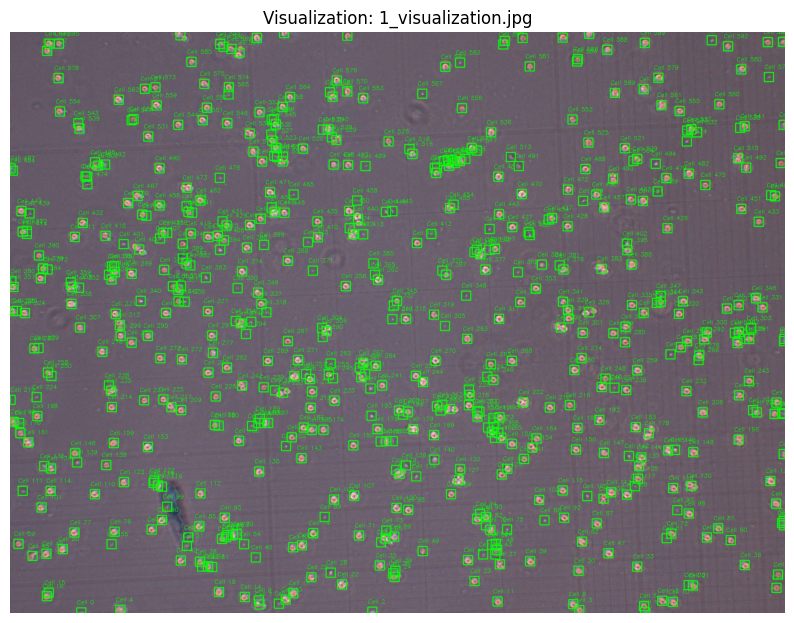

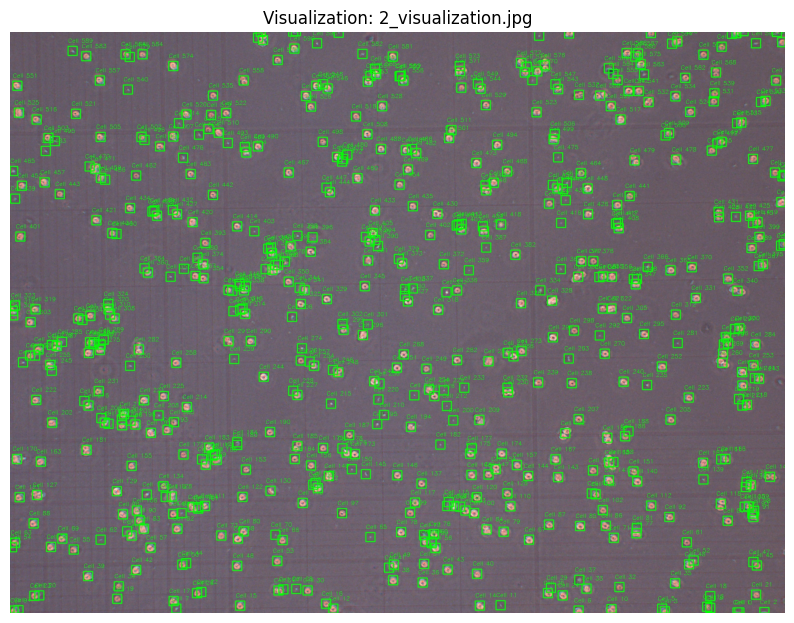

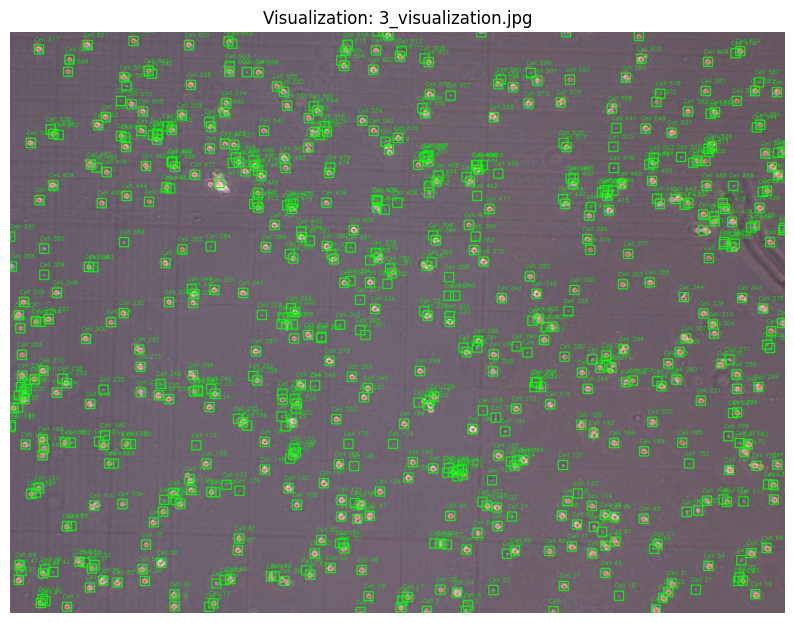

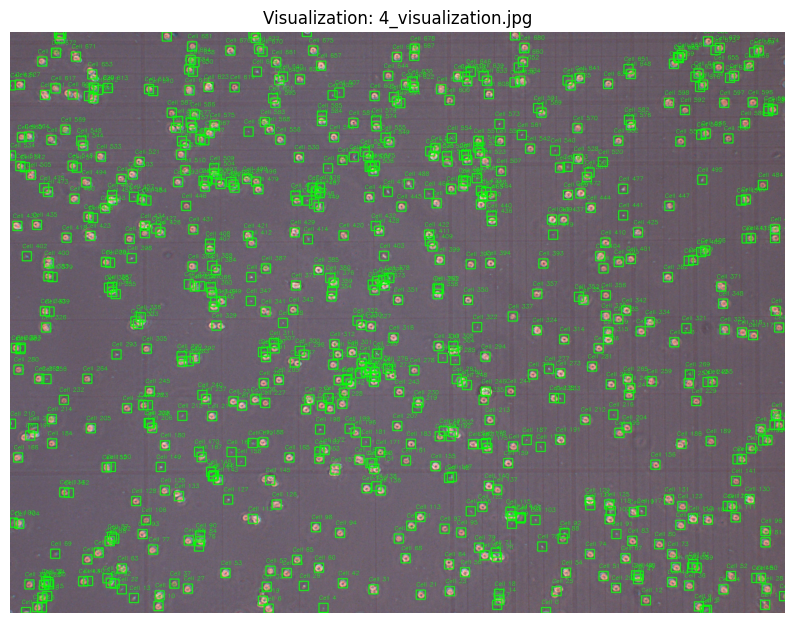

In [30]:
import matplotlib.pyplot as plt
import cv2
import os

# 시각화 이미지 디렉토리 경로
visualization_dir = "/home/jinjinjara1022/AI_Term/cell_survival_rate/Dataset/visualizations"

# 시각화 디렉토리 내 파일 리스트 가져오기
visualization_files = sorted(
    [os.path.join(visualization_dir, f) for f in os.listdir(visualization_dir) if f.lower().endswith((".jpg", ".png"))]
)

# 각 시각화 이미지를 순차적으로 표시
for vis_path in visualization_files:
    # 시각화 이미지 로드
    visualization_image = cv2.imread(vis_path)
    visualization_image = cv2.cvtColor(visualization_image, cv2.COLOR_BGR2RGB)

    # 이미지 표시
    plt.figure(figsize=(10, 10))
    plt.imshow(visualization_image)
    plt.title(f"Visualization: {os.path.basename(vis_path)}")
    plt.axis('off')
    plt.show()


**생성된 cell_detection에 대해서 직접 라벨링**

# Data Load

In [53]:
import os
from PIL import Image
from torchvision import transforms

# 데이터셋 경로
base_dir = "Dataset"

# 사용할 클래스만 선택
allowed_classes = ["alive", "misclassified"]
selected_dirs = [os.path.join(base_dir, cls) for cls in allowed_classes]

# 데이터 증강 설정
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),        # 항상 좌우 반전
    transforms.RandomRotation(degrees=30),         # -30도 ~ +30도 사이 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기 및 대비 조정
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),  # 위치 변환
])

# 저장 디렉토리 생성
augmented_dir = "AugmentedDataset"
os.makedirs(augmented_dir, exist_ok=True)

# 데이터 증강 수행
augmentation_multiplier = 10  # 10배 증강
total_augmented_images = 0

for idx, cls_dir in enumerate(selected_dirs):
    class_name = allowed_classes[idx]
    class_augmented_dir = os.path.join(augmented_dir, class_name)
    os.makedirs(class_augmented_dir, exist_ok=True)

    for filename in os.listdir(cls_dir):
        if filename.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".tif", ".tiff")):  # 이미지 파일만 필터링
            image_path = os.path.join(cls_dir, filename)
            image = Image.open(image_path).convert("RGB")

            # 원본 이미지 저장
            image.save(os.path.join(class_augmented_dir, filename))

            # 데이터 증강 및 저장
            for i in range(augmentation_multiplier - 1):  # 원본 포함 총 10배
                augmented_image = augment_transform(image)
                new_filename = f"{os.path.splitext(filename)[0]}_aug_{i}.jpg"
                augmented_image.save(os.path.join(class_augmented_dir, new_filename))
                total_augmented_images += 1

print(f"총 증강된 이미지 수: {total_augmented_images}")
print(f"증강된 데이터셋 경로: {augmented_dir}")

총 증강된 이미지 수: 22860
증강된 데이터셋 경로: AugmentedDataset


In [57]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 데이터셋 경로
base_dir = "AugmentedDataset"

# 사용할 클래스만 선택
allowed_classes = ["alive", "misclassified"]
selected_dirs = [os.path.join(base_dir, cls) for cls in allowed_classes]

# 데이터 전처리 및 증강
transform = transforms.Compose([
    transforms.Resize((64, 64)),                   # 크기 조정
    transforms.RandomHorizontalFlip(p=0.5),        # 좌우 반전 (50% 확률)
    transforms.RandomRotation(degrees=30),         # -30도 ~ +30도 사이 회전
    transforms.ToTensor(),                         # Tensor로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5],    # RGB 각 채널 정규화
                         std=[0.5, 0.5, 0.5])
])

# 선택된 클래스 데이터셋 로드
image_paths = []
labels = []
for idx, cls_dir in enumerate(selected_dirs):
    for filename in os.listdir(cls_dir):
        if filename.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".tif", ".tiff")):  # 이미지 파일만 필터링
            image_paths.append(os.path.join(cls_dir, filename))
            labels.append(idx)

# 데이터 확인
print(f"로드된 이미지 수: {len(image_paths)}")
print(f"클래스 레이블: {allowed_classes}")

로드된 이미지 수: 25400
클래스 레이블: ['alive', 'misclassified']


In [58]:
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# 데이터셋 생성
custom_dataset = CustomImageDataset(image_paths=image_paths, labels=labels, transform=transform)


In [59]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# 데이터셋 분할
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42  # 20%를 테스트 데이터로 사용
)

# 훈련 데이터셋 및 테스트 데이터셋 생성
train_dataset = CustomImageDataset(image_paths=train_paths, labels=train_labels, transform=transform)
test_dataset = CustomImageDataset(image_paths=test_paths, labels=test_labels, transform=transform)

# 데이터 로더 정의
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 확인
print(f"훈련 데이터 수: {len(train_dataset)}")
print(f"테스트 데이터 수: {len(test_dataset)}")

훈련 데이터 수: 20320
테스트 데이터 수: 5080


In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1. GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 장치: {device}")

# 2. 모델 정의 (Pretrained 모델 사용 - ResNet)
class CellClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(CellClassifier, self).__init__()
        # ResNet18 모델 불러오기 (사전 학습된 가중치 사용)
        self.base_model = models.resnet18(pretrained=True)
        # 마지막 레이어 출력 크기를 num_classes로 변경
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

model = CellClassifier(num_classes=3).to(device)

# 3. 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 학습 루프
epochs = 10
for epoch in range(epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass 및 옵티마이저 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 통계 업데이트
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

print("모델 학습 완료!")

사용 중인 장치: cuda


/home/jinjinjara1022/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jinjinjara1022/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.0946, Accuracy: 96.89%
Epoch 2/10, Loss: 0.0583, Accuracy: 97.89%
Epoch 3/10, Loss: 0.0543, Accuracy: 97.97%
Epoch 4/10, Loss: 0.0484, Accuracy: 98.24%
Epoch 5/10, Loss: 0.0398, Accuracy: 98.50%
Epoch 6/10, Loss: 0.0418, Accuracy: 98.47%
Epoch 7/10, Loss: 0.0387, Accuracy: 98.54%
Epoch 8/10, Loss: 0.0354, Accuracy: 98.58%
Epoch 9/10, Loss: 0.0340, Accuracy: 98.73%
Epoch 10/10, Loss: 0.0325, Accuracy: 98.75%
모델 학습 완료!


In [62]:
from sklearn.metrics import classification_report

# 클래스 이름 직접 지정
target_names = ["alive", "misclassified"]

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# sklearn을 사용하여 클래스별 성능 평가
print(classification_report(all_labels, all_preds, target_names=target_names))

               precision    recall  f1-score   support

        alive       1.00      1.00      1.00      4391
misclassified       0.97      0.97      0.97       689

     accuracy                           0.99      5080
    macro avg       0.98      0.98      0.98      5080
 weighted avg       0.99      0.99      0.99      5080



# Real Test

In [79]:
import cv2
import os

# 테스트 이미지 경로와 출력 디렉토리 설정
test_image_path = "/home/jinjinjara1022/AI_Term/cell_survival_rate/Test/test.jpg"
output_dir = "/home/jinjinjara1022/AI_Term/cell_survival_rate/Test/cell_detection"
visualization_dir = "/home/jinjinjara1022/AI_Term/cell_survival_rate/Test/visualizations"

# 출력 디렉토리 생성
os.makedirs(output_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)

# 고정된 바운딩 박스 크기
box_width = 24
box_height = 24

# 테스트 이미지 로드
image = cv2.imread(test_image_path)  # 컬러 이미지 그대로 로드

# 그레이스케일 변환 (세포 탐지를 위해 사용)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 이진화 및 경계 검출
_, thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 디텍션된 경계 상자를 원본 이미지에 그리기
visualization_image = image.copy()  # 시각화를 위해 원본 이미지를 복사
cell_count = 0

for i, contour in enumerate(contours):
    # 세포의 중심점 계산
    M = cv2.moments(contour)
    if M["m00"] == 0:  # 면적이 0인 경우 건너뛰기
        continue
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])

    # 고정된 크기의 바운딩 박스 좌표 계산
    x1 = max(0, center_x - box_width // 2)
    y1 = max(0, center_y - box_height // 2)
    x2 = min(image.shape[1], center_x + box_width // 2)
    y2 = min(image.shape[0], center_y + box_height // 2)

    # 경계 상자 그리기
    cv2.rectangle(visualization_image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 녹색 테두리
    # 각 세포의 번호 표시
    cv2.putText(visualization_image, f"Cell {cell_count}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # 컬러 이미지에서 고정된 크기로 세포 영역 자르기 및 저장
    cell = image[y1:y2, x1:x2]
    cell_output_path = os.path.join(output_dir, f"test_cell_{cell_count}.jpg")
    cv2.imwrite(cell_output_path, cell)  # 컬러 이미지 저장
    cell_count += 1

# 시각화된 이미지를 저장
visualization_output_path = os.path.join(visualization_dir, "test_visualization.jpg")
cv2.imwrite(visualization_output_path, visualization_image)

print(f"테스트 이미지에서 {cell_count}개의 컬러 세포 이미지 저장 완료!")
print(f"시각화 결과 저장 경로: {visualization_output_path}")

테스트 이미지에서 197개의 컬러 세포 이미지 저장 완료!
시각화 결과 저장 경로: /home/jinjinjara1022/AI_Term/cell_survival_rate/Test/visualizations/test_visualization.jpg


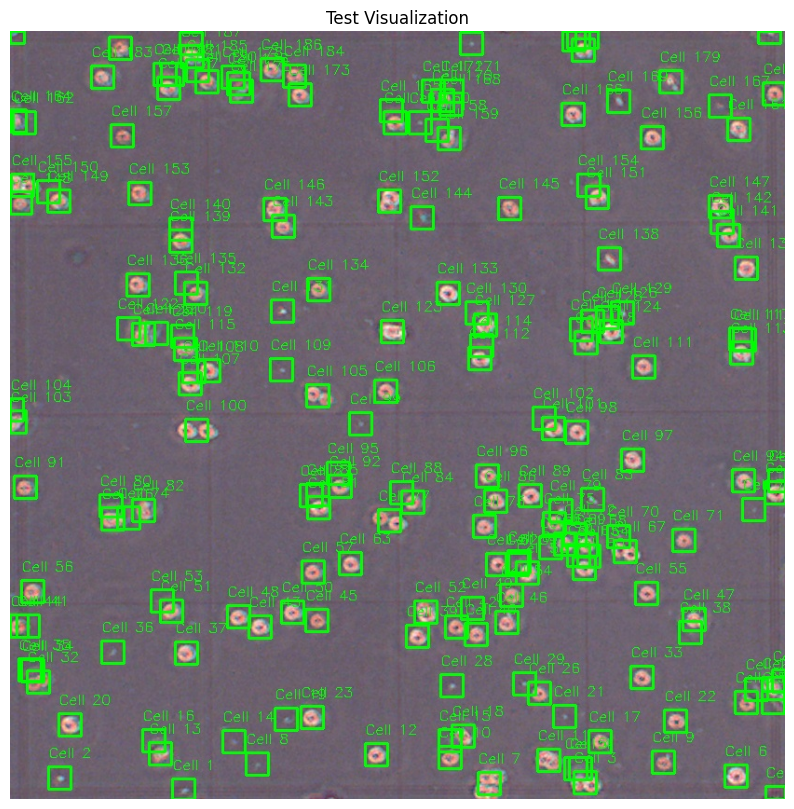

In [80]:
import matplotlib.pyplot as plt
import cv2

# 시각화 결과 이미지 경로
visualization_result_path = "/home/jinjinjara1022/AI_Term/cell_survival_rate/Test/visualizations/test_visualization.jpg"

# 이미지 로드
visualization_image = cv2.imread(visualization_result_path)
visualization_image = cv2.cvtColor(visualization_image, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR로 로드하므로 RGB로 변환

# 이미지 시각화
plt.figure(figsize=(10, 10))
plt.imshow(visualization_image)
plt.axis('off')
plt.title("Test Visualization")
plt.show()

In [81]:
# 6. 이미지 분류
test_images_dir = "/home/jinjinjara1022/AI_Term/cell_survival_rate/Test/cell_detection"

# 테스트 데이터 구성
test_image_paths = [
    os.path.join(test_images_dir, fname)
    for fname in os.listdir(test_images_dir)
    if fname.lower().endswith((".jpg", ".png", ".jpeg"))
]

# 더미 레이블 생성 (테스트 데이터에는 실제 레이블이 필요하지 않으므로 0으로 설정)
dummy_labels = [0] * len(test_image_paths)

# 데이터셋 생성
R_test_dataset = CustomImageDataset(image_paths=test_image_paths, labels=dummy_labels, transform=transform)
R_test_loader = DataLoader(R_test_dataset, batch_size=32, shuffle=False)

In [82]:
model.eval()  # 평가 모드로 설정

# 클래스 이름 정의
allowed_classes = ["alive", "misclassified"]

# 결과 저장용 딕셔너리 초기화
classification_results = {cls: 0 for cls in allowed_classes}

# 4. 테스트 데이터 예측
print("테스트 데이터 예측 시작...")
for images, _ in R_test_loader:  # 데이터 로더에서 배치 가져오기, 레이블은 사용하지 않음
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)  # 모델에 이미지 입력
        _, predicted = torch.max(outputs, 1)  # 가장 높은 확률의 클래스 선택

    # 예측 결과를 집계
    for pred in predicted:
        class_name = allowed_classes[pred.item()]
        classification_results[class_name] += 1

# 5. 결과 출력
print("\n테스트 데이터 분류 결과:")
for cls, count in classification_results.items():
    print(f"{cls}: {count}개")


테스트 데이터 예측 시작...

테스트 데이터 분류 결과:
alive: 124개
misclassified: 73개
